In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import time
import os
from IPython.display import display, clear_output
import helpfunction as helper
import matplotlib.patches as patches

pd.set_option('display.max_columns', 500)

In [3]:
%autoreload

In [4]:
gr = (1 + 5 ** 0.5) / 2
outdir= './output/NuMuCC/'
inputdir = './input/JuneStopMu/run1_v12/' 
main_tree_name= 'pandoraSliceId' #'pandoraFlashEventBuilding

In [5]:
dict_names = ['nue','nu','on','off', 'dirt']

fidvol_vtx = [10,10,10,10,10,50] 
fidvol_end = [5,5,5,5,5,5]

lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]

mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

In [11]:
#triggers_off = 15060902
#triggers_on = 10701086
#pot_on = 4.535e19
#pot_nue = 4.69e+22
#pot_nu = 2.42e+20
#pot_dirt = 1.08e+20

triggers_off = 18141621
triggers_on = 9872165
pot_on = 4.54e+19
pot_nue = 3.795e+22
pot_nu = 6.992e+19
pot_dirt = 1.004e+20

title_str = "MicroBooNE {0:.2g} POT, INTERNAL".format(pot_on)
sig_str = r"$\nu_e \: CC$"
scale_off = triggers_on / triggers_off
scale_nu = pot_on / pot_nu
scale_nue = pot_on / pot_nue
scale_on = 1
scale_dirt = pot_on / pot_dirt

#['nue','nu','on','off', 'dirt'] 
scales = [scale_nue, scale_nu, scale_on, scale_off, scale_dirt]
scales= [0.0011653863322641975, 0.5565550114199108, 1, 0.3681945523793476, 0.4495829555594153]
print(scales)

[0.0011653863322641975, 0.5565550114199108, 1, 0.3681945523793476, 0.4495829555594153]


In [12]:
def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)
    
def inTPC_mask(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    mask = inTPC_mask(df, str_x, str_y, str_z, fidvol)
    return df[mask]

def cosmic_angles(mom_x, mom_y, mom_z,df_out=True):
    theta_beam = np.arctan2(np.sqrt(np.square(mom_x)+np.square(mom_y)),mom_z)
    phi_beam = np.arctan2(mom_y,mom_x)
    if df_out:
        return pd.DataFrame({'theta':theta_beam, 'phi':phi_beam})[['theta','phi']]
    else:
        return np.array([theta_beam, phi_beam])

In [13]:
file_dict = {}
tree_names = ['']

flist =  os.listdir(inputdir)
for sample,scale in zip(dict_names, scales):
    file_name = next((s for s in flist if "NuCC_"+sample+"_" in s), None)
    file_dict[sample] = {}
    file_dict[sample]["all_events"] = uproot.open(inputdir+file_name)[main_tree_name+'/events']
    file_dict[sample]["slices"] = uproot.open(inputdir+file_name)[main_tree_name+'/slices']
    file_dict[sample]["events"] = uproot.open(inputdir+file_name)['nuCCAnalyser/Event']
    file_dict[sample]["daughters"] = uproot.open(inputdir+file_name)['nuCCAnalyser/Daughters']

    print(sample+":\tAll events: ", file_dict[sample]["all_events"].numentries, end="")
    print("\tSelected events: ", file_dict[sample]["events"].numentries, end="")
    print("\tScaled to data: ", round(file_dict[sample]["events"].numentries*scale))

nue:	All events:  81529	Selected events:  67223	Scaled to data:  78
nu:	All events:  82641	Selected events:  37401	Scaled to data:  20816
on:	All events:  182495	Selected events:  48679	Scaled to data:  48679
off:	All events:  352895	Selected events:  64648	Scaled to data:  23803
dirt:	All events:  38053	Selected events:  9795	Scaled to data:  4404


In [14]:
sample = "nu"
for name in file_dict[sample]:
    print('\n*** ', name, ' ***')
    print([c.decode('UTF-8') for c in file_dict[sample][name].keys()])


***  daughters  ***
['event', 'run', 'subrun', 'evt_time_sec', 'evt_time_nsec', 'hitsU', 'hitsV', 'hitsY', 'caloU', 'caloV', 'caloY', 'hitsSps', 'generation', 'track_score', 'is_shower', 'is_track', 'has_shower_daughter', 'is_track_daughter', 'vx', 'vy', 'vz', 'vtx_distance', 'track_length', 'track_endx', 'track_endy', 'track_endz', 'track_dirx', 'track_diry', 'track_dirz', 'track_range_mom_p', 'track_range_mom_mu', 'track_mcs_mom', 'track_mcs_err', 'track_mcs_ll', 'track_chi2_proton', 'track_chi2_muon', 'shower_length', 'shower_openangle', 'shower_dirx', 'shower_diry', 'shower_dirz', 'start_dedxU', 'start_dedxV', 'start_dedxY', 'start_hitsU', 'start_hitsV', 'start_hitsY', 'start_pitchU', 'start_pitchV', 'start_pitchY', 'mc_neutrino', 'mc_vx', 'mc_vy', 'mc_vz', 'mc_vx_sce', 'mc_vy_sce', 'mc_vz_sce', 'mc_length', 'mc_energy', 'mc_px', 'mc_py', 'mc_pz']

***  events  ***
['event', 'run', 'subrun', 'evt_time_sec', 'evt_time_nsec', 'numpfp', 'hitsU', 'hitsV', 'hitsY', 'caloU', 'caloV', 'c

In [15]:
#plt.hist(file_dict["nu"]["daughters"].array("track_mcs_mom"), range=(0,3),bins=20)
neutrino = (file_dict["nu"]["daughters"].array("mc_neutrino")) & (file_dict["nu"]["daughters"].array("track_length")>5)
muons = (file_dict["nu"]["daughters"].array("mc_pdg")==13) & neutrino
protons = (file_dict["nu"]["daughters"].array("mc_pdg")==2212) & neutrino
pions = (file_dict["nu"]["daughters"].array("mc_pdg")==211) & neutrino


data1 = [ file_dict["nu"]["daughters"].array("track_chi2_proton")[muons],
          file_dict["nu"]["daughters"].array("track_chi2_proton")[protons],
          file_dict["nu"]["daughters"].array("track_chi2_proton")[pions]
       ]
data2 = [ file_dict["nu"]["daughters"].array("track_chi2_muon")[muons],
         file_dict["nu"]["daughters"].array("track_chi2_muon")[protons],
          file_dict["nu"]["daughters"].array("track_chi2_muon")[pions]
       ]
data3 = [ file_dict["nu"]["daughters"].array("track_length")[muons],
         file_dict["nu"]["daughters"].array("track_length")[protons],
          file_dict["nu"]["daughters"].array("track_length")[pions]
       ]
data4 = [ file_dict["nu"]["daughters"].array("track_score")[muons],
         file_dict["nu"]["daughters"].array("track_score")[protons],
          file_dict["nu"]["daughters"].array("track_score")[pions]
       ]

data5 = [data1[0]/data2[0], data1[1]/data2[1], data1[2]/data2[2]]

data6 = [ file_dict["nu"]["daughters"].array("vtx_distance")[muons],
         file_dict["nu"]["daughters"].array("vtx_distance")[protons],
          file_dict["nu"]["daughters"].array("vtx_distance")[pions]
       ]

labs = [r'$\nu$ muons', r'$\nu$ protons', r'$\nu$ pions']

fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(9*gr,4))
ax[0].hist(data1, label=labs, range=(0,350), histtype='step', bins=50, lw=2)
ax[0].axvspan(40, 350, alpha=0.2, color="green")
ax[0].legend()
ax[0].set_xlabel(r'Proton $\chi^2$')
ax[0].set_title('Proton $\chi^2$')
ax[1].hist(data2, label=labs, range=(0,100), histtype='step', bins=50, lw=2)
ax[1].axvspan(0, 60, alpha=0.2, color="green")
ax[1].legend()
ax[1].set_xlabel(r'Muon $\chi^2$')
ax[1].set_title('Muon $\chi^2$')
ax[2].hist2d(data1[0], data2[0], bins=50, range=((0,350),(0,100)), cmap='coolwarm', norm=LogNorm())
ax[2].add_patch(patches.Rectangle( (40, 0), 310, 60, alpha=0.2, color='g'))
ax[2].set_xlabel(r'Proton $\chi^2$')
ax[2].set_ylabel(r'Muon $\chi^2$')
ax[2].set_title('Muons')
ax[3].hist2d(data1[1], data2[1], bins=50, range=((0,350),(0,100)), cmap='coolwarm', norm=LogNorm())
ax[3].add_patch(patches.Rectangle( (40, 0), 310, 60, alpha=0.2, color='g'))

ax[3].set_xlabel(r'Proton $\chi^2$')
ax[3].set_ylabel(r'Muon $\chi^2$')
ax[3].set_title('Protons')
fig.tight_layout()
fig.show()
fig.savefig(outdir+'muon_canidate1.pdf')


fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(9*gr,4))
ax[0].hist(data3, label=labs, range=(0,350), histtype='step', bins=50, lw=2)
ax[0].legend()
ax[0].set_xlabel(r'Track length [cm]')
ax[0].axvspan(20, 350, alpha=0.2, color="green")
ax[0].set_title('Track length')
ax[1].hist(data4, label=labs, range=(0.6,1), histtype='step', bins=50, lw=2)
ax[1].axvspan(0.8, 1, alpha=0.2, color="green")
ax[1].set_yscale('log')
ax[1].legend(loc=2)
ax[1].set_xlabel(r'Track score')
ax[1].set_title('Track score')
ax[2].hist(data5, label=labs, range=(0,50), histtype='step', bins=50, lw=2)
ax[2].axvspan(2, 50, alpha=0.2, color="green")
ax[2].set_xlabel(r'Proton $\chi^2$ / Muon $\chi^2$')
ax[2].set_title(r'Proton $\chi^2$ / Muon $\chi^2$')
ax[2].legend()
ax[3].hist(data6, label=labs, range=(0,6), histtype='step', bins=50, lw=2)
ax[3].axvspan(0, 4, alpha=0.2, color="green")
ax[3].set_xlabel(r'Vertex Distance [cm]')
ax[3].set_title(r'Vertex Distance')
ax[3].set_yscale('log')
ax[3].legend()
fig.tight_layout()
fig.show()
fig.savefig(outdir+'muon_candidate2.pdf')

KeyError: "not found: b'mc_pdg'"

In [11]:
df_daughters = [file_dict[sample]["daughters"].pandas.df() for sample in dict_names]

In [12]:
# for the nu events:
cols = ['mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_lepton_energy', 'mc_nu_lepton_theta','mc_nu_ccnc', 
        'mc_nu_pdg', 'mc_nu_lepton_px', 'mc_nu_lepton_py', 'mc_nu_lepton_pz', 'mc_nu_vtx_distance',
        'evt_time_sec', 'evt_time_nsec']
df_nu_event = file_dict['nu']["events"].pandas.df(cols)
nu_tpc_mask = inTPC_mask( df_nu_event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz')
df_nu_event['mc_nu_fid_vol'] = inTPC_mask( df_nu_event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol=fidvol_vtx)
df_nu_event[['theta_beam','phi_beam']] = cosmic_angles(*df_nu_event[['mc_nu_lepton_px', 'mc_nu_lepton_py', 'mc_nu_lepton_pz']].T.values)
df_nu_event['hash'] = eventHash(df_nu_event[['evt_time_sec', 'evt_time_nsec']])

nu_sig_mask = df_nu_event.eval('mc_nu_lepton_energy>@kin_min_mu & ~mc_nu_ccnc & abs(mc_nu_pdg)==14 & mc_nu_fid_vol')

In [13]:
# Add a bunch of stuff to the daughter frames to do the selection
for i,s in enumerate(dict_names):
    start = time.time()
    print(s)
    df_daughters[i]['hash'] = eventHash(df_daughters[i][['evt_time_sec', 'evt_time_nsec']])
    
    # do for all:
    start_mask = inTPC_mask(df_daughters[i], 'vx', 'vy', 'vz', fidvol_vtx)
    end_mask = inTPC_mask(df_daughters[i], 'track_endx', 'track_endy', 'track_endz', fidvol_end)
    df_daughters[i]['contained'] = start_mask & end_mask 
    df_daughters[i]['start_contained'] = start_mask
    df_daughters[i]['all_contained'] = df_daughters[i].groupby(['hash'])['contained'].transform(all)
    df_daughters[i]['all_start_contained'] = df_daughters[i].groupby(['hash'])['start_contained'].transform(all)
    
    # Add the pandora PDG code of the parent:
    df_event = file_dict[s]["events"].pandas.df(['evt_time_sec','evt_time_nsec','nu_pdg', 'caloY','num_tracks', 'num_showers'])
    df_event['hash'] = eventHash(df_event[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_event['hash'],df_event['nu_pdg']))
    df_daughters[i]['nu_pdg'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],df_event['caloY']))
    df_daughters[i]['caloY'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],df_event['num_tracks']))
    df_daughters[i]['num_tracks'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],df_event['num_showers']))
    df_daughters[i]['num_showers'] = df_daughters[i]['hash'].map(mapper)
    
    df_all_event = file_dict[s]["all_events"].pandas.df(['evt_time_sec','evt_time_nsec','bestCosmicMatch'])
    df_all_event['hash'] = eventHash(df_all_event[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_all_event['hash'],df_all_event['bestCosmicMatch']))
    df_daughters[i]['bestCosmicMatch'] = df_daughters[i]['hash'].map(mapper)
    
    # Add the topological score and the chi2
    if s in ['nu','nue']:
        df_slices = file_dict[s]["slices"].pandas.df(['evt_time_sec','evt_time_nsec','topologicalScore', 'flashMatchScore', 'isTaggedAsTarget', 'minCRTdist', 'purity','completeness'])
    else:
        df_slices = file_dict[s]["slices"].pandas.df(['evt_time_sec','evt_time_nsec','topologicalScore', 'flashMatchScore', 'isTaggedAsTarget', 'minCRTdist'])
    df_slices = df_slices.query('isTaggedAsTarget')
    df_slices['hash'] = eventHash(df_slices[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_slices['hash'],df_slices['topologicalScore']))
    df_daughters[i]['topologicalScore'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_slices['hash'],df_slices['flashMatchScore']))
    df_daughters[i]['flashMatchScore'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_slices['hash'],df_slices['minCRTdist']))
    df_daughters[i]['minCRTdist'] = df_daughters[i]['hash'].map(mapper)
    
    # there can be only one muon candidate per event!
    df_daughters[i]['muon_candidate'] = df_daughters[i].eval('track_score>0.8 & vtx_distance<4 & track_chi2_proton>40 & track_chi2_muon<60 & (track_chi2_proton/track_chi2_muon)>2 & track_length>5')
    df_daughters[i].loc[df_daughters[i]['muon_candidate'], 'longest_muon_candidate_length'] = df_daughters[i].query('muon_candidate').groupby(['hash'])['track_length'].transform(max)
    df_daughters[i].loc[~df_daughters[i]['muon_candidate'], 'longest_muon_candidate_length'] = -1

    #do for mc only 
    if s in ['nu','nue']:
        mapper = dict(zip(df_event['hash'],nu_tpc_mask))
        df_daughters[i]['mc_nu_in_tpc'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],nu_sig_mask))
        df_daughters[i]['mc_nu_cc_sig'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_lepton_energy')))
        df_daughters[i]['mc_nu_lepton_energy'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_lepton_theta')))
        df_daughters[i]['mc_nu_lepton_theta'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_vtx_distance')))
        df_daughters[i]['mc_nu_vtx_distance'] = df_daughters[i]['hash'].map(mapper)
        
        mapper = dict(zip(df_slices['hash'],df_slices['purity']))
        df_daughters[i]['purity'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_slices['hash'],df_slices['completeness']))
        df_daughters[i]['completeness'] = df_daughters[i]['hash'].map(mapper)
    
    end = time.time()
    print("Passed time: {0:0.1f}s".format(end - start))

nue
Passed time: 46.0s
nu
Passed time: 54.3s
on
Passed time: 34.8s
off
Passed time: 63.9s
dirt
Passed time: 7.1s


In [14]:
for i,s in enumerate(dict_names):
    df_daughters[i][['theta_beam','phi_beam']] = cosmic_angles(*df_daughters[i][['track_dirx', 'track_diry', 'track_dirz']].T.values)

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


In [15]:
#### Selection queries
query_select_wo_trackcut = 'nu_pdg==14 & (flashMatchScore<10 | topologicalScore>0.25) & all_start_contained & longest_muon_candidate_length==track_length & topologicalScore>0.06 & (flashMatchScore/bestCosmicMatch)<2'
query_select = query_select_wo_trackcut+' & track_length>20'
query_pure = 'purity>0.5 & abs(mc_pdg)==13' # & mc_nu_vtx_distance<5
query_event = query_select+' & '+query_pure

In [16]:
# how much nue events pass 
len(df_daughters[0].query('0.05 < mc_nu_lepton_energy & mc_nu_lepton_energy < 1.5').query(query_select))/pot_nue*6.6e20

62.608695652173914

In [17]:
# Efficiency
df_daughters[0] = df_daughters[1].query('mc_nu_cc_sig')
eff = len(df_daughters[0].query(query_select).query(query_pure))/sum(nu_sig_mask)*100
print(eff)

56.93473979550544


In [18]:
# Selected hashes: 
selected_hashes = df_daughters[0].query(query_event)['hash']
df_daughters[0].query(query_select)['mc_pdg'].value_counts()/len(df_daughters[0].query(query_select))

 13      0.904186
 2212    0.049338
 211     0.028748
-13      0.006536
 2112    0.004742
-211     0.004571
 22      0.001666
 321     0.000214
Name: mc_pdg, dtype: float64

0.9099696739954511

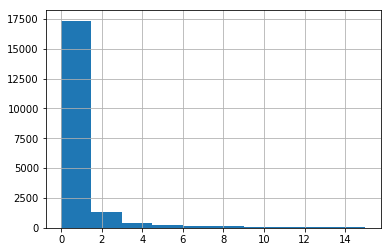

In [19]:
# Of the events I select, how much are actually reconstructed at the vertex
df_nu_event[df_nu_event['hash'].isin(selected_hashes)]['mc_nu_vtx_distance'].hist(range=(0,15))
sum(df_nu_event[df_nu_event['hash'].isin(selected_hashes)]['mc_nu_vtx_distance']<5)/len(selected_hashes)

In [20]:
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

[0.22687083701161595, 0.22687083701161595, 1, 0.23010754722510962, 0.3675004681395844, 0.22687083701161595]


In [21]:
# Purity
# on_contribution = df_daughters[2].query(query_event)*scales_here[2]
off_contribution = len(df_daughters[3].query(query_select))*scales_here[3]
nu_contribution = len(df_daughters[1].query(query_select))*scales_here[1]
dirt_contribution = len(df_daughters[4].query(query_select))*scales_here[4]

purity= len(df_daughters[0].query(query_select).query(query_pure))*scales_here[0] / (off_contribution+nu_contribution+dirt_contribution)
print(purity)

0.5788854246900602


In [22]:
df_nu_event.keys()

Index(['mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_lepton_energy',
       'mc_nu_lepton_theta', 'mc_nu_ccnc', 'mc_nu_pdg', 'mc_nu_lepton_px',
       'mc_nu_lepton_py', 'mc_nu_lepton_pz', 'mc_nu_vtx_distance',
       'evt_time_sec', 'evt_time_nsec', 'mc_nu_fid_vol', 'theta_beam',
       'phi_beam', 'hash'],
      dtype='object')

In [23]:
## From now on we wil lalso put reco quality requirements on the 
df_daughters[0]=df_daughters[0].query(query_pure)

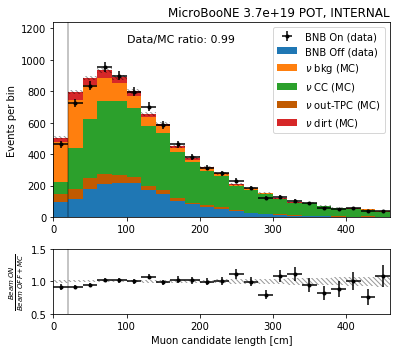

In [24]:
#track plot
fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(3.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})

# Left
lab = 'Muon candidate length [cm]'
N=23
x_min = 0
x_max = 460
data = [df_daughters[i].query(query_select_wo_trackcut)['track_length'] for i,s in enumerate(dict_names)]
data[1] = df_daughters[1].query(query_select_wo_trackcut)['track_length']
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select_wo_trackcut).query('~mc_nu_in_tpc')['track_length'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0].set_ylabel('Events per bin')
ax[0].set_title(title_str, loc='right')
ax[0].set_ylim(0,1.3*max_val[2])
ax[0].text(100, ax[0].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0].set_xlim(x_min,x_max)
ax[0].axvline(x=20, color='k', alpha=0.3)
ax[0].legend()

# Ratio plots
ax[1].set_ylim(0.5,1.5)
ax[1].set_xlim(x_min,x_max)
ax[1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1].set_xlabel(lab)
ax[1].axvline(x=20, color='k', alpha=0.3)

fig.tight_layout()
fig.savefig(outdir+"numu_tracklength.pdf", bbox_inches="tight")

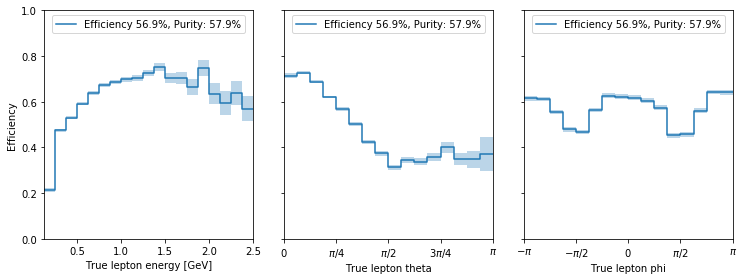

In [25]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(6.5*gr,4), sharey=True)

# Left
x_min = 0.125
x_max = 2.5
N = 19
denom = df_nu_event['mc_nu_lepton_energy'][nu_sig_mask]
nom = df_daughters[0].query(query_event)['mc_nu_lepton_energy']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton energy [GeV]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')


# Middle
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
x_min = 0
x_max = np.pi
N = 16
denom = df_nu_event['theta_beam'][nu_sig_mask]
nom =  df_nu_event[df_nu_event['hash'].isin(selected_hashes)]['theta_beam']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'True lepton theta')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)

# Right
x_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
x_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$',r'$\pi/2$',r'$\pi$']
x_min = -np.pi
x_max = np.pi
N = 16
denom = df_nu_event['phi_beam'][nu_sig_mask]
nom =  df_nu_event[df_nu_event['hash'].isin(selected_hashes)]['phi_beam']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[2].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[2].set_xlabel(r'True lepton phi')
ax[2].set_ylim(0,1)
ax[2].set_xlim(x_min, x_max)
ax[2].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[2].legend(loc='upper center')
ax[2].set_xticks(x_ticks)
ax[2].set_xticklabels(x_labels)

fig.tight_layout()
fig.savefig(outdir+"eff.pdf", bbox_inches="tight")

[0.22687083701161595, 0.22687083701161595, 1, 0.23010754722510962, 0.3675004681395844, 0.22687083701161595]


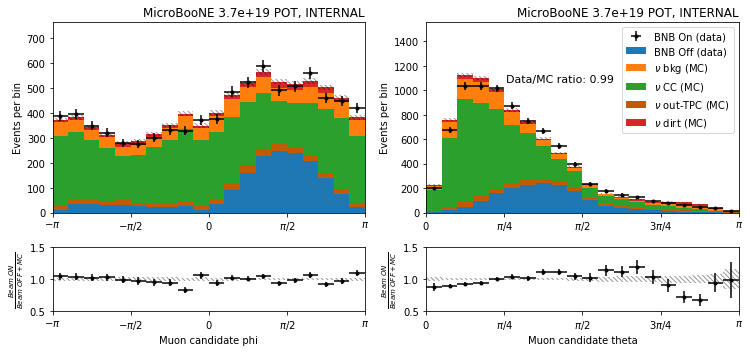

In [26]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Muon candidate phi'
x_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
x_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$',r'$\pi/2$',r'$\pi$']
N=20
x_min = -np.pi
x_max = np.pi
data = [df_daughters[i].query(query_select)['phi_beam'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['phi_beam'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][0].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][0].set_ylabel('Events per bin')
ax[0][0].set_title(title_str, loc='right')
ax[0][0].set_ylim(0,1.3*max_val[2])
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)
ax[0][0].set_xlim(x_min,x_max)

# Ratio plots
ax[1][0].set_ylim(0.5,1.5)
ax[1][0].set_xlim(x_min,x_max)
ax[1][0].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].set_xlabel(lab)
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)

# Right
lab = 'Muon candidate theta'
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']

N=20
x_min = 0
x_max = np.pi
data = [df_daughters[i].query(query_select)['theta_beam'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['theta_beam'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0][1].text(0.8, ax[0][1].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0][1].legend()
ax[0][1].set_ylabel('Events per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.5*max_val[2])
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)
ax[0][1].set_xlim(x_min,x_max)

# Ratio plots
ax[1][1].set_ylim(0.5,1.5)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_xlabel(lab)
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)

fig.tight_layout()
fig.savefig(outdir+"numu_phi_theta.pdf", bbox_inches="tight")

[0.22687083701161595, 0.22687083701161595, 1, 0.23010754722510962, 0.3675004681395844, 0.22687083701161595]


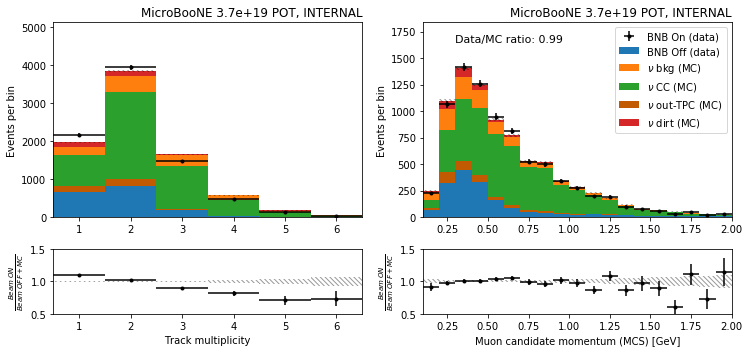

In [27]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Track multiplicity'
N=6
x_min = 0.5
x_max = 6.5
data = [df_daughters[i].query(query_select)['num_tracks'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['num_tracks'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][0].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][0].set_ylabel('Events per bin')
ax[0][0].set_title(title_str, loc='right')
ax[0][0].set_ylim(0,1.3*max_val[2])
ax[0][0].set_xticks(range(7))
ax[0][0].set_xlim(x_min,x_max)

# Ratio plots
ax[1][0].set_ylim(0.5,1.5)
ax[1][0].set_xticks(range(7))
ax[1][0].set_xlim(x_min,x_max)
ax[1][0].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].set_xlabel(lab)



# Right
lab = 'Muon candidate momentum (MCS) [GeV]'
N=19
x_min = 0.1
x_max = 2.0
data = [df_daughters[i].query(query_select)['track_mcs_mom'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['track_mcs_mom'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0][1].legend()
ax[0][1].set_ylabel('Events per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.3*max_val[2])
ax[0][1].text(0.3, ax[0][1].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0][1].set_xlim(x_min,x_max)

# Ratio plots
ax[1][1].set_ylim(0.5,1.5)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_xlabel(lab)

fig.tight_layout()
fig.savefig(outdir+"numu_tracks_mom.pdf", bbox_inches="tight")

In [28]:
# Fidvol ratio:
#fidvol_vtx = [10,10,10,10,10,50] 
#lower = [-1.55, -115.53, 0.1]
#upper = [254.8, 117.47, 1036.9]

fv1=1
for i in range(3):
    fv1*=((upper[i]-fidvol_vtx[2*i]) - (lower[i]+fidvol_vtx[2*i+1]))
print(fv1)

fv2=(233-70)*(256.35-24)*(1036.8-25-100-85)
fv1/fv2

49174602.84


1.5703993681020856

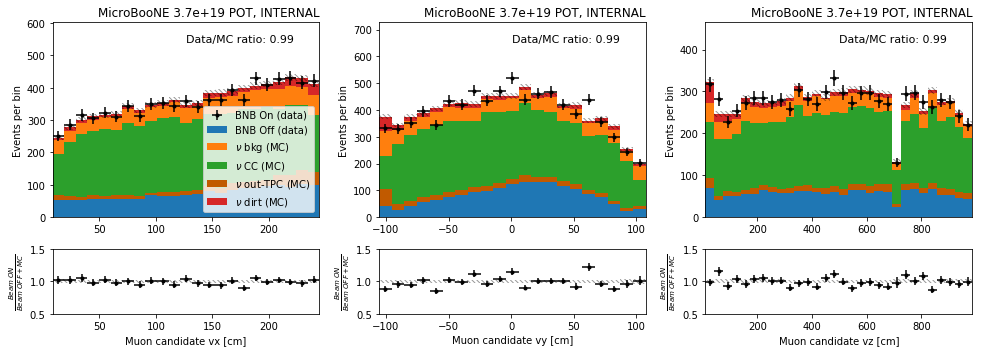

In [29]:
# VTX efficiency in function of the xyz coordinates and also the efficiencies!
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(8.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})

field_arr = ['vx', 'vy', 'vz']
lab_arr = ['Muon candidate vx [cm]', 'Muon candidate vy [cm]', 'Muon candidate vz [cm]']
x_min_arr = lower+np.array([10,10,10])
x_max_arr = upper-np.array([10,10,50])

for i, (x_min, x_max, lab, field) in enumerate(zip(x_min_arr, x_max_arr, lab_arr, field_arr)):
    N = int(round(x_max-x_min)/10)
    N = min(N,30)
    data = [df_daughters[i].query(query_select)[field] for i,s in enumerate(dict_names)]
    # I need an in-tpc version of the BNB nu sample:
    data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')[field])
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])
    # Data/MC
    ax[0][i].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
    ax[0][i].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

    ax[0][i].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
    ax[0][i].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
    ax[0][i].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
    ax[0][i].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

    y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
    val = bins[3]+bins[1]+bins[4]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[0][i].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
        sc_err = e/v
        ax[1][i].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

    ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
    ax[0][i].set_ylabel('Events per bin')
    ax[0][i].set_title(title_str, loc='right')
    ax[0][i].set_ylim(0,1.4*max_val[2])
    ax[0][i].text(x_min+(x_max-x_min)*0.5, ax[0][i].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
    ax[0][i].set_xlim(x_min,x_max)

    # Ratio plots
    ax[1][i].set_ylim(0.5,1.5)
    ax[1][i].set_xlim(x_min,x_max)
    ax[1][i].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
    ax[1][i].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
    ax[1][i].set_xlabel(lab)

ax[0][0].legend()
fig.tight_layout()
fig.savefig(outdir+"numu_reco_muon_vtx.pdf", bbox_inches="tight")

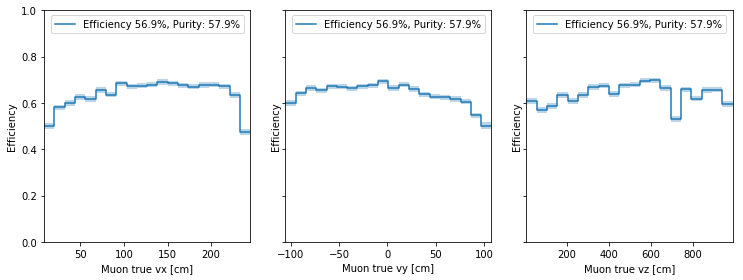

In [30]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(6.5*gr,4), sharey=True)

# Left
field_arr = ['mc_vx', 'mc_vy', 'mc_vz']
lab_arr = ['Muon true vx [cm]', 'Muon true vy [cm]', 'Muon true vz [cm]']
x_min_arr = lower+np.array([10,10,10])
x_max_arr = upper-np.array([10,10,50])
N=20

for i, (x_min, x_max, lab, field) in enumerate(zip(x_min_arr, x_max_arr, lab_arr, field_arr)):
    denom = df_daughters[0].drop_duplicates('hash')[field]
    nom = df_daughters[0].query(query_event)[field]
    data = [denom, nom]
    edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
    fraq = bins[1]/bins[0]
    err = np.sqrt( fraq*(1-fraq)/bins[0] )
    fraq= np.append(fraq,fraq[-1])
    err = np.append(err,err[-1]) 

    ax[i].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
    ax[i].set_xlabel(lab)
    ax[i].set_ylabel('Efficiency')
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(x_min, x_max)
    ax[i].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
    ax[i].legend(loc='upper center')

fig.tight_layout()
fig.savefig(outdir+"numu_eff_muon_vtx.pdf", bbox_inches="tight")

[0.22687083701161595, 0.22687083701161595, 1, 0.23010754722510962, 0.3675004681395844, 0.22687083701161595]


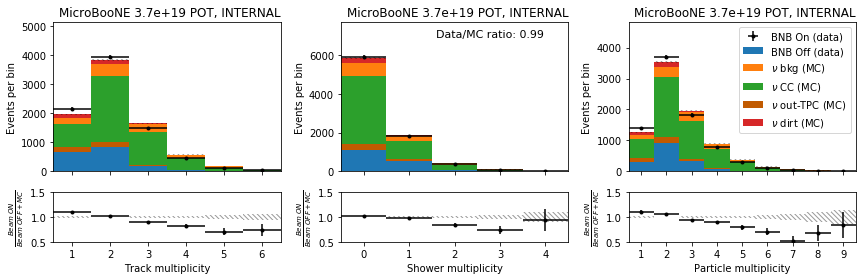

In [31]:
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7.5*gr,4), sharex='col', gridspec_kw = {'height_ratios':[3, 1]})
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Track multiplicity'
N=6
x_min = 0.5
x_max = 6.5
data = [df_daughters[i].query(query_select)['num_tracks'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['num_tracks'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][0].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][0].set_ylabel('Events per bin')
ax[0][0].set_title(title_str, loc='right')
ax[0][0].set_ylim(0,1.3*max_val[2])

# Ratio plots
ax[1][0].set_ylim(0.5,1.5)
ax[1][0].set_xticks(range(7))
ax[1][0].set_xlim(x_min,x_max)
ax[1][0].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].set_xlabel(lab)


# Left
lab = 'Shower multiplicity'
N=5
x_min = -0.5
x_max = 4.5
data = [df_daughters[i].query(query_select)['num_showers'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['num_showers'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][1].set_ylabel('Events per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.3*max_val[2])
ax[0][1].text(1.6, ax[0][1].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
# Ratio plots
ax[1][1].set_ylim(0.5,1.5)
ax[1][1].set_xticks(range(5))
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_xlabel(lab)



# Right
lab = 'Particle multiplicity'
N=9
x_min = 0.5
x_max = 9.5
data = [df_daughters[i].query(query_select).eval('num_showers+num_tracks') for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc').eval('num_showers+num_tracks'))
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][2].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][2].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

ax[0][2].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][2].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][2].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][2].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][2].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][2].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0][2].legend()
ax[0][2].set_ylabel('Events per bin')
ax[0][2].set_title(title_str, loc='right')
ax[0][2].set_ylim(0,1.3*max_val[2])

# Ratio plots
ax[1][2].set_ylim(0.5,1.5)
ax[1][2].set_xticks(range(10))
ax[1][2].set_xlim(x_min,x_max)
ax[1][2].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][2].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][2].set_xlabel(lab)

fig.tight_layout()
fig.savefig(outdir+"numu_showers_pfp.pdf", bbox_inches="tight")